### Pradedam nuo nurodymo į duomenis (photo). Vienas aplanakas jame 6 nuotraukos tyrimo objekto is 6 nuotraukos kalibracinės panelės.

In [1]:
## auto perkraunam variables pradedam iš naujo
%load_ext autoreload
%autoreload 2

#### Užsikraunam visiškai visas reikalingas bibliotekas

In [2]:
#Įtraukiam visas reikalingas bibliotekas
import micasense.image as image
import micasense.capture as capture
import micasense.panel as panel
import micasense.imageutils as imageutils
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import time
import cv2
from pathlib import Path
from skimage.transform import ProjectiveTransform

#### Nuorodos į domenis 1D objektai su 6 pavadinimais 

In [3]:
#folderis kur visos foto ir tyrimo ir kalibracijos, nuotraukų setų pavadinimai
imagePath = Path("../data/tabakas_ground")

#tyriamo objekto nuotraukų setas IMG_****_*.tif micasense pavadinimo formatas
imageNames = list(imagePath.glob('IMG_0000_*.tif'))
imageNames = [x.as_posix() for x in imageNames]

#kalibracinės paneles objekto nuotraukų setas IMG_****_*.tif micasense pavadinimo formatas
panelNames = list(imagePath.glob('IMG_0008_*.tif'))
panelNames = [x.as_posix() for x in panelNames]

#patikrinimas
print(f"Tyrimo objekto nuotraukų setas ({len(imageNames)}):")
for name in imageNames: print(f" - {os.path.basename(name)}")
#patikrinimas
print(f"\nKalibracinės panelės nuotraukų setas ({len(panelNames)}):")
for name in panelNames: print(f" - {os.path.basename(name)}")

Tyrimo objekto nuotraukų setas (6):
 - IMG_0000_1.tif
 - IMG_0000_2.tif
 - IMG_0000_3.tif
 - IMG_0000_4.tif
 - IMG_0000_5.tif
 - IMG_0000_6.tif

Kalibracinės panelės nuotraukų setas (6):
 - IMG_0008_1.tif
 - IMG_0008_2.tif
 - IMG_0008_3.tif
 - IMG_0008_4.tif
 - IMG_0008_5.tif
 - IMG_0008_6.tif


#### Sukuriam "capture" objektus, vienas tyrimo obejekto fotografijom antras kalibracinės panelės fotografijom

In [4]:
#du capture objektai, tai ir yra visi duomenys sugrupuoti/nurodyti "capture" obejktuose

#prisilaikom thecapture pavadinimo tokį naudoja micasence bibliotekas kūrėjai
thecapture = capture.Capture.from_filelist(imageNames)
#prisilaikom panelCap pavadinimo tokį naudoja micasence bibliotekas kūrėjai
panelCap = capture.Capture.from_filelist(panelNames)

#kameros duomenys, kamera turim tik viena bet d4l pasitikrinimo paliekam
cam_model = thecapture.camera_model
cam_serial = thecapture.camera_serial

#pasitikrinam ką realiai nuskaitėm
print("Camera model:",cam_model)
print("Bit depth:", thecapture.bits_per_pixel)
#print("Camera serial number:", cam_serial)
print("Capture 'image' ID:",thecapture.uuid)
print("Capture 'panel' ID:",panelCap.uuid)



Camera model: RedEdge-P
Bit depth: 16
Capture 'image' ID: jPhfjf3tLA6zR3HDFRNk
Capture 'panel' ID: TJ8NNdhAM7m781NQte65


#### Irradiance and Reflectance Apšievtimas ir atspindžiai

In [5]:
#Pagal panelės foto ir jos sukalibruotą žinomą atspindžio vertę(albedo) ~0.5
#apskaičiuoja "irradiance" t.y. saulės energiją konkrečioje spektro dalyje red green blue NIR red edge ir panchro
#gaunam 6 skaičius kiekvienai panelės nuotraukai po skaičių
irradiance_list = panelCap.panel_irradiance(panelCap.panel_albedo())

#paimam kiekvieną tiriama nuotrauką apskaičiuojam jos atspindžio energija padauginam iš pi nes atsispindi į visas puses
#ir padalinam iš krintančios saulės energijos kurią gavom iš panelės nuotraukos ir gaunąm santikį(atspindžio vertę) nuo 0.0 iki 1.0 kuria dalį atspindėjo ir taip kiekvienam pikseliui.
thecapture.compute_reflectance(irradiance_list)
print("Visos tiriamos nuotraukos perskaičiuotos į atspindžių vertes(Reflectance)")

print("Spectro dalies energija apskaičiuota pagal kalibracinę panelę kiekvienai spectro daliai(Irradiance)\n")



print(f"{'Band':<20} : {'Irradiance':<20} :  {'Avg Reflectance'}")
print("-" * 60)

for i, img in enumerate(thecapture.images):
    # Get irradiance from your list using index i
    irr_val = irradiance_list[i]
    
    # Calculate average reflectance for the current band
    avg_ref = np.mean(img.reflectance())
    
    print(f"{img.band_name:20} : {irr_val:6.2f} W/m²/band     :{avg_ref:8.4f} avg. reflec.")



Visos tiriamos nuotraukos perskaičiuotos į atspindžių vertes(Reflectance)
Spectro dalies energija apskaičiuota pagal kalibracinę panelę kiekvienai spectro daliai(Irradiance)

Band                 : Irradiance           :  Avg Reflectance
------------------------------------------------------------
Blue                 :  12.26 W/m²/band     :  0.2755 avg. reflec.
Green                :   9.72 W/m²/band     :  0.6356 avg. reflec.
Red                  :   2.19 W/m²/band     :  0.6074 avg. reflec.
NIR                  :   0.77 W/m²/band     :  0.8855 avg. reflec.
Red edge             :   1.32 W/m²/band     :  0.6752 avg. reflec.
Panchro              :  36.23 W/m²/band     :  0.4791 avg. reflec.


#### Sulygiavimas. Turim šešias nuotraukas, visos truputį prasislinkę nes lešiai ne vienoje vietoje o prasislinkę.

In [6]:
st = time.time()

warp_matrices_SIFT = thecapture.SIFT_align_capture(min_matches = 50)
        
sharpened_stack, upsampled = thecapture.radiometric_pan_sharpened_aligned_capture(warp_matrices=warp_matrices_SIFT, irradiance_list=irradiance_list, img_type='radiance')

print("Pansharpened shape:", sharpened_stack.shape)
print("Upsampled shape:", upsampled.shape)

# re-assign to im_aligned to match rest of code 
im_aligned = upsampled
et = time.time()
elapsed_time = et - st
print('Alignment and pan-sharpening time:', int(elapsed_time), 'seconds')



Pansharpened shape: (1899, 2437, 6)
Upsampled shape: (1899, 2437, 6)
Alignment and pan-sharpening time: 24 seconds


In [8]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(30,23)   # use this size for export-sized display

rgb_band_indices = [thecapture.band_names_lower().index('red'),
                    thecapture.band_names_lower().index('green'),
                    thecapture.band_names_lower().index('blue')]

# Create normalized stacks for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32)
im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

rgb = im_display[:,:,rgb_band_indices]


plt.figure(figsize=(16, 16))
plt.imshow(rgb)
plt.axis('off')
plt.show()

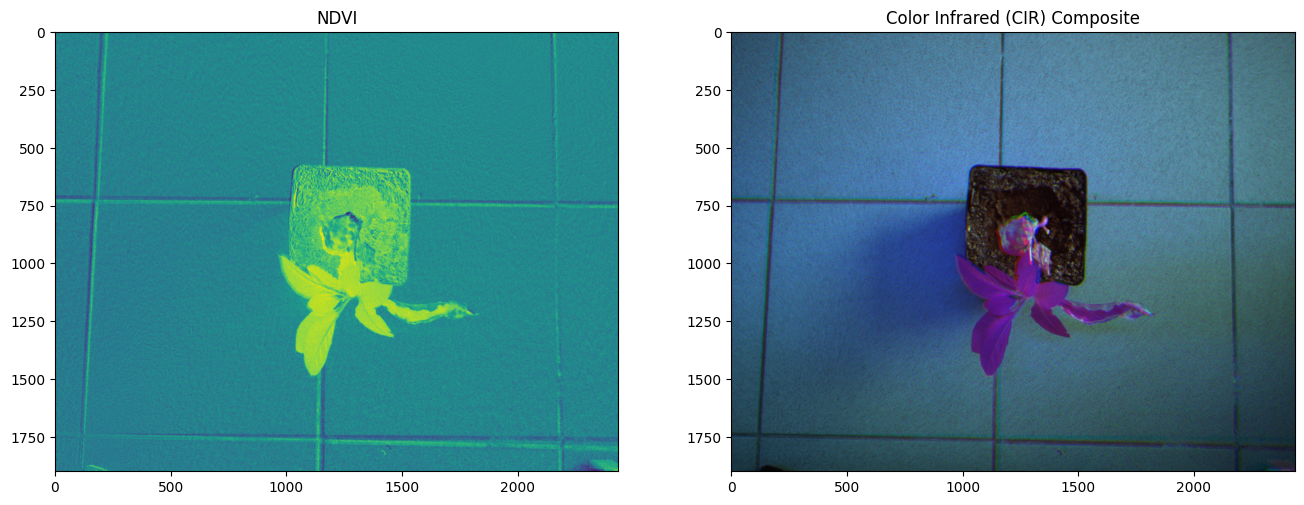

In [9]:
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [thecapture.band_names_lower().index('red'),
                    thecapture.band_names_lower().index('green'),
                    thecapture.band_names_lower().index('blue')]
cir_band_indices = [thecapture.band_names_lower().index('nir'),
                    thecapture.band_names_lower().index('red'),
                    thecapture.band_names_lower().index('green')]

# Create normalized stacks for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32)
im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values


im_display_sharp = np.zeros((sharpened_stack.shape[0],sharpened_stack.shape[1],sharpened_stack.shape[2]), dtype=np.float32 )
im_min_sharp = np.percentile(sharpened_stack[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max_sharp = np.percentile(sharpened_stack[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values


# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    
    im_display_sharp[:,:,i] = imageutils.normalize(sharpened_stack[:,:,i], im_min_sharp, im_max_sharp)

rgb = im_display[:,:,rgb_band_indices]


rgb_sharp = im_display_sharp[:,:,rgb_band_indices]

nir_band = thecapture.band_names_lower().index('nir')
red_band = thecapture.band_names_lower().index('red')

ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=figsize)

ax1.set_title("Red-Green-Blue Composite")
ax1.imshow(rgb)

ax2.set_title("Red-Green-Blue Composite (pan-sharpened)")
ax2.imshow(rgb_sharp)

fig, (ax3,ax4) = plt.subplots(1, 2, figsize=figsize)
ax3.set_title("NDVI")
ax3.imshow(ndvi)
ax4.set_title("Color Infrared (CIR) Composite")
ax4.imshow(cir)

# set custom lims if you want to zoom in to image to see more detail 
# this is useful for comparing upsampled and pan-sharpened stacks 
# custom_xlim=(1500,2000)
# custom_ylim=(2000,1500)
# plt.setp([ax1,ax2,ax3,ax4], xlim=custom_xlim, ylim=custom_ylim)

plt.show()

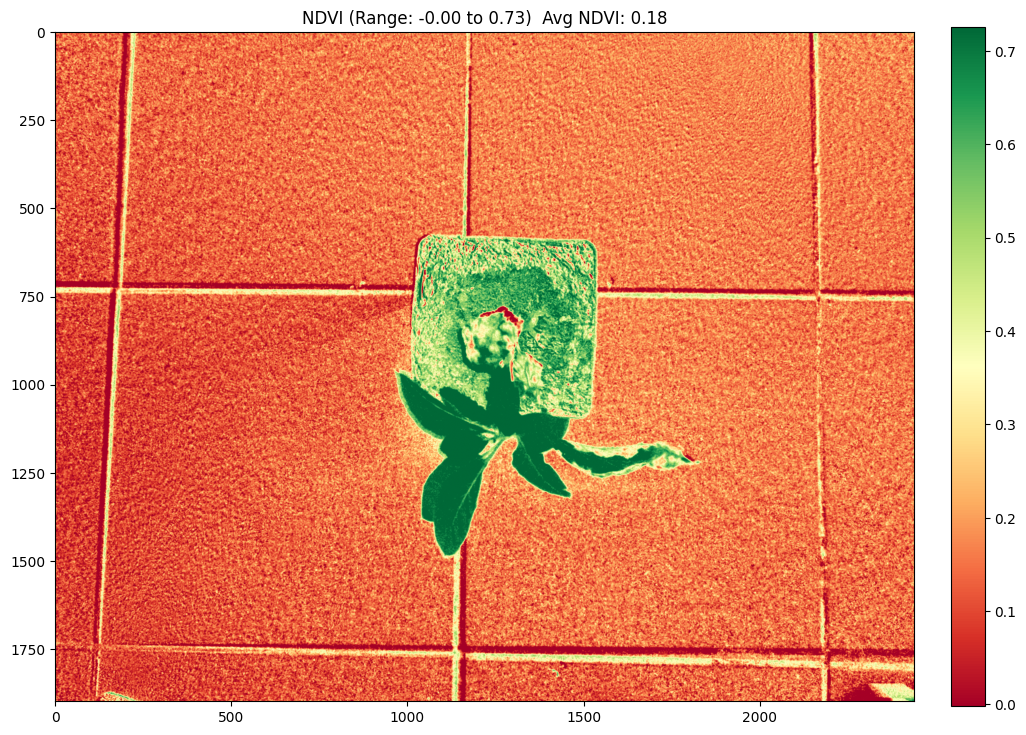

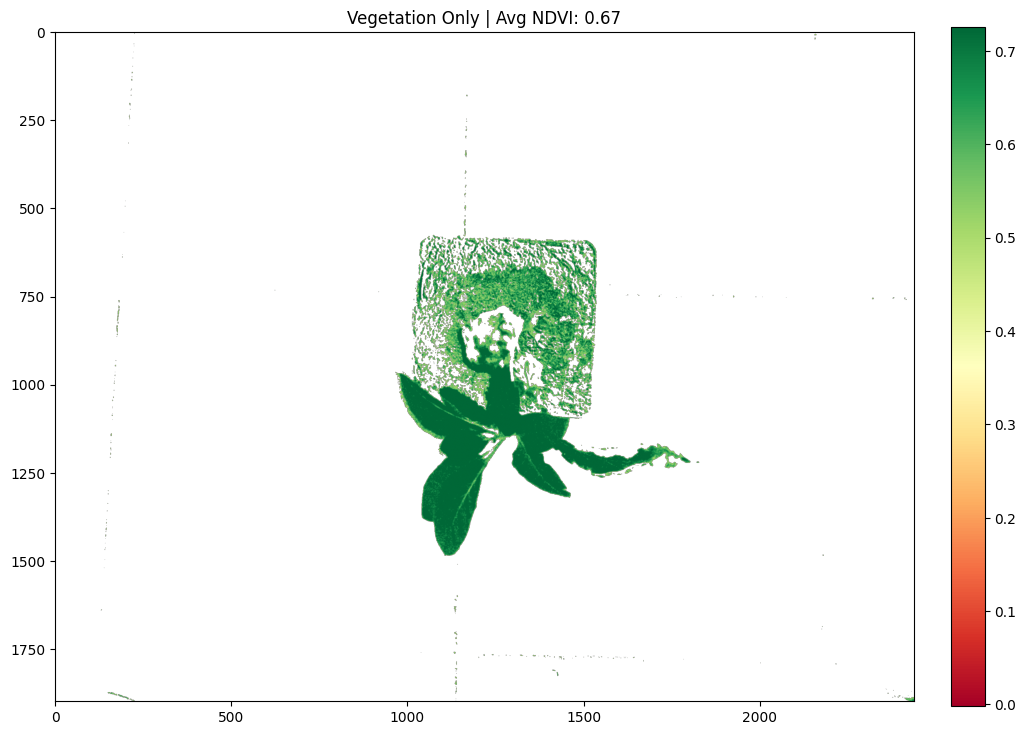

In [39]:
#NDVI

nir_band = thecapture.band_names_lower().index('nir')
red_band = thecapture.band_names_lower().index('red')

ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])
avg_ndvi = np.nanmean(ndvi)

vmin = np.nanpercentile(ndvi, 2)
vmax = np.nanpercentile(ndvi, 98)

# 3. Plot with specific limits
plt.figure(figsize=(12,10))
plt.title(f"NDVI (Range: {vmin:.2f} to {vmax:.2f})  Avg NDVI: {avg_ndvi:.2f}")

# use vmin and vmax to map the colorbar exactly to your data
im = plt.imshow(ndvi, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.0365, pad=0.04)
plt.show()

# 1. Define your threshold
# 0.3 is a common cutoff for soil vs. sparse vegetation
threshold = 0.5

# 2. Create the mask
# This creates an array of True/False values
vegetation_mask = ndvi > threshold

# 3. Apply the mask
# We create a copy so we don't destroy the original ndvi data
ndvi_masked = ndvi.copy()
ndvi_masked[~vegetation_mask] = np.nan  # ~ means "NOT", so we hide everything below threshold
avg_ndvi = np.nanmean(ndvi_masked)

# 2. Plot with the average in the title
plt.figure(figsize=(12,10))
# Using an f-string to format the title with 2 decimal places
plt.title(f"Vegetation Only | Avg NDVI: {avg_ndvi:.2f}")


# Use 'none' for the background color of NaNs
im = plt.imshow(ndvi_masked, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.colorbar(im, fraction=0.0365, pad=0.04)
plt.show()